In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 23 10:06:33 2020

@author: tsuyogbasnet
"""

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [3]:
#calculate fft @params signal and rate
def calculate_fft(signal, rate):
    signal_length = len(signal)
    frequency = np.fft.rfftfreq(signal_length, d = 1/rate)
    #mean normalization of length of signal
    magnitude = abs(np.fft.rfft(signal)/signal_length) 
    return (magnitude, frequency)


In [4]:
#calculate low and hig frequency because we have dead spots in signal
#we do this to get atleats a threshold value of amps
def envelope(signal, rate, threshold):
    mask = []
    signal = pd.Series(signal).apply(np.abs)
    signal_mean = signal.rolling(window=int(rate/10), min_periods = 1, center = True).mean()
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


In [5]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [7]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [8]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [9]:
## file operations

##read file labels
data_frame = pd.read_csv('instruments.csv')
data_frame.set_index('fname', inplace=True)

print('Extract files with labels')
for f in tqdm(data_frame.index):
    rate, signal = wavfile.read('sounds/'+f)
    data_frame.at[f, 'length'] = signal.shape[0]/rate


classes = list(np.unique(data_frame.label))
class_dist = data_frame.groupby(['label'])['length'].mean()


data_frame.reset_index(inplace=True)

##datapoints
signals = {}
fft = {}
fbank = {}
mfccs = {}

print("Reading audio files with librosa")
for c in tqdm(classes):
    wav_file = data_frame[data_frame.label == c].iloc[0,0]
    signal, rate = librosa.load('sounds/'+wav_file, sr=44100)
    
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calculate_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


In [26]:
#writing cleaned files for training
if len(os.listdir('cleanfiles')) >= 1:
    print("Writing clean files for calssification training")
    for f in tqdm(data_frame.fname):
        try:
            signal, rate = librosa.load('sounds/'+f, sr = 16000)
            mask = envelope(signal, rate, 0.0005)
            wavfile.write(filename='cleanfiles/'+f, rate = rate, data= signal[mask])
        except FileNotFoundError:
            print("Unexpected error while reading files:", arg)
else:
    print("please clean your directory or existing files will be used")

please clean your directory or existing files will be used


In [24]:
#writing files for testing
print(os.listdir('testcleanfiles'))
if len(os.listdir('testcleanfiles')) >= 1:
    print("Writing clean files for calssification")
    for f in tqdm(data_frame.fname):
        try:
            signal, rate = librosa.load('testsounds/'+f, sr = 16000)
            mask = envelope(signal, rate, 0.0005)
            wavfile.write(filename='testcleanfiles/'+f, rate = rate, data= signal[mask])
        except FileNotFoundError:
            print("Unexpected error while reading files:", arg)
else:
    print("please clean your directory or existing files will be used")

0%|          | 0/300 [00:00<?, ?it/s]['.DS_Store']
Writing clean files for calssification
100%|██████████| 300/300 [01:39<00:00,  3.01it/s]


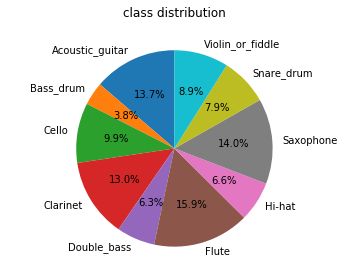

In [12]:
#plot class distribution
fig, ax = plt.subplots()
ax.set_title("class distribution", y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

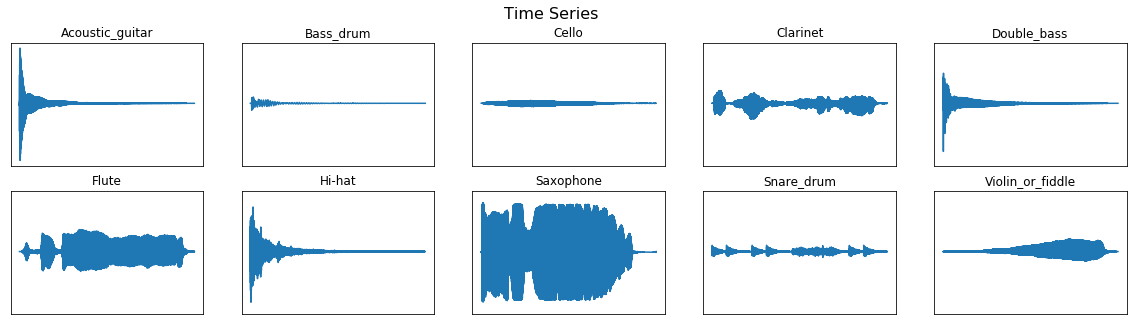

In [13]:
#plot raw signal
plot_signals(signals)
plt.show()

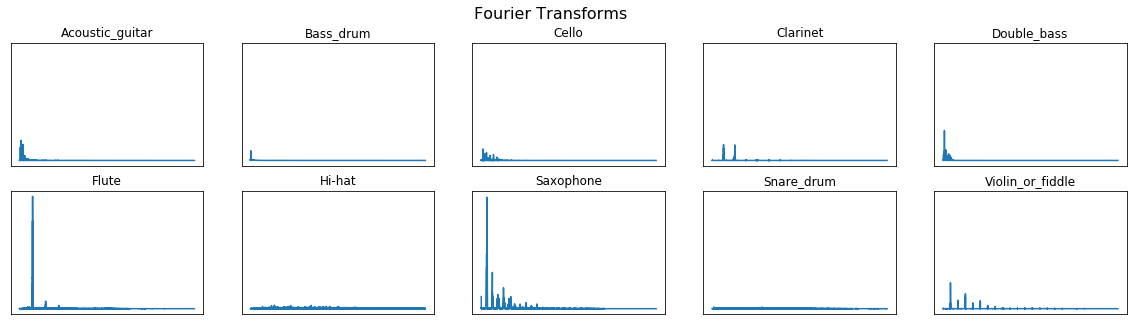

In [14]:
#plot fft signals
plot_fft(fft)
plt.show()


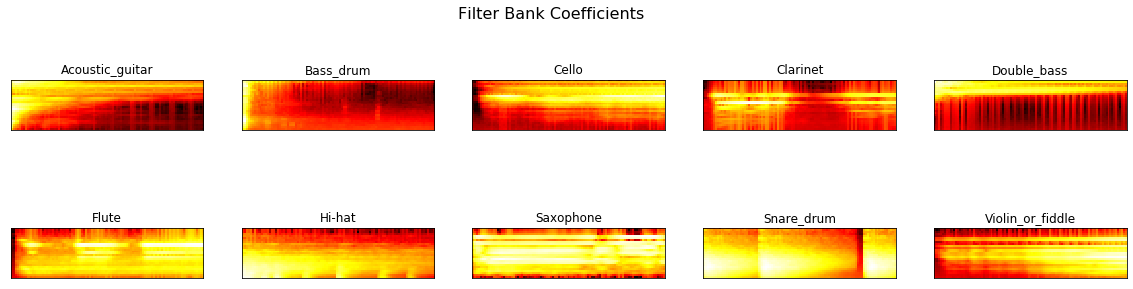

In [15]:
#plot Filter bank energy
plot_fbank(fbank)
plt.show()

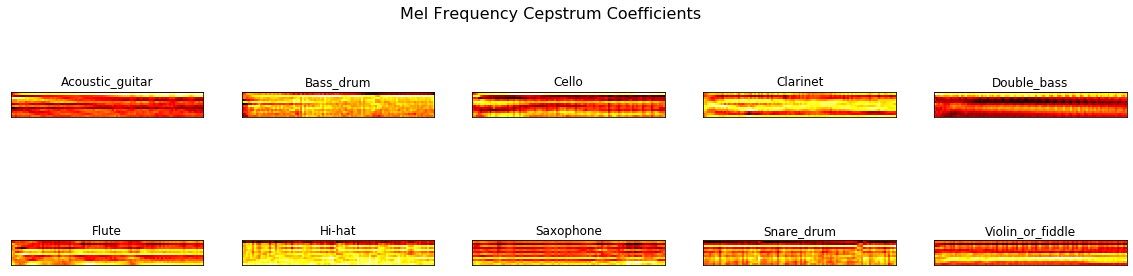

In [16]:
#plot mfcc 

plot_mfccs(mfccs)
plt.show()